In [18]:
import numpy as np
import pandas as pd
import time
import sklearn
import ipywidgets as widgets
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from ipywidgets import interact, interactive, fixed, interact_manual
from mlxtend.plotting import plot_decision_regions
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier 
%matplotlib inline
%matplotlib notebook

readdata = pd.read_csv("/home/dom/Documents/MPhys/TheGrandTour/wine_data.txt", sep="\t", header=None);
data = np.array(readdata);
data = np.delete(data, 0, 0)
data = data.astype(float)
data = np.swapaxes(data,0,1)


# Need to seperate the classification dimension:
classification = data[13]
data = np.delete(data, 13, axis=0)


# make list of colours for each number:
data_colour = []
data_marker = []
for i in range(len(classification)):
    if classification[i] == 1:
        data_colour.append("r")
        data_marker.append("x")
    elif classification[i] == 2:
        data_colour.append("b")
        data_marker.append("o")
    elif classification[i] == 3:
        data_colour.append("g")
        data_marker.append("*")
        
# Normalizes the data        
for i in range(0, np.shape(data)[0]):
    data[i,:] = (data[i,:] / np.ndarray.max(data[i,:])) * 2 - 1
    
        


#VARIABLES
stepSize = 0.01
nSteps = 10000

def getAlpha(d):
    """
    NEEDS IMPLEMENTATION
    Should produce 1xd(d-1)/2 array of position in grand tour.
    """
    p = d*(d-1)/2     
    primeList = []
    count = 1
    while len(primeList) < p:
        count += 1
        primeBool = False
        for i in range(2, count - 1):
            if count % i == 0:
                primeBool = True
        if primeBool == False:
            irrational = (np.sqrt(count)%1)
            primeList.append(irrational)
            
    primeList = np.asarray(primeList)
    primeList = primeList.dot(stepSize)
    """
    Irrational number generation using exponentials, not being used
    p = int(d*(d-1)/2)
    alpha = np.zeros(p) #alpha(t) parameters defining grand tour in G2,d
    for i in range(0,p):
        alpha[i] = (np.exp(i) % 1) * 2 * np.pi
        
    alpha = alpha.dot(0.001)
    """
    
    
    return primeList


def getAngles(alpha,d):
    """""
    Inputs: 
    alpha = 1xd(d-1)/2 array defining position on grand tour
    d = dimensions of data
    Outputs a dxd array of angles required for the transformation
    """
    theta = np.zeros((d,d));
    i = 0;
    k = 0;
    
    while i < d-1:
        j = i + 1;
        
        while j < d:
            theta[i][j] = alpha[k];
            j += 1;
            k += 1;
    
        i+= 1;
        
    return theta;


def RotationMatrix(i, j, d, theta):
    """
    Inputs:
    i = first indicie of rotating plane
    j = second indicie of rotating plane
    d = dimensions of data
    theta = dxd array of angle of rotation of rotating plane
    Outputs a rotating matrix to rotate plane of ixj plane by theta_ij
    """
    R = np.identity(d)
    R[i,i] = np.cos(theta)
    R[i,j] = -1*np.sin(theta)
    R[j,i] = np.sin(theta)
    R[j,j] = np.cos(theta)
    return R


def BetaFn(d, theta):
    """
    Inputs:
    d = dimensions of data
    theta = dxd array of angle of rotation ixj plane
    Outputs the full matrix transformation for all rotations
    """
    b = RotationMatrix(0, 1, d, theta[0,1])
    i = 0
    j = 1
    for i in range(d):
        for j in range(d):
            if j <= i:
                continue
            if i==0 and j==1:
                continue
            b = np.matmul(b, RotationMatrix(i, j, d, theta[i,j]))
            
    return b


def GrandTour(data, nSteps):
    """
    Inputs:
    data = array of data points, dimensions x npoints
    Outputs a 3D array number of points x t x dimensions, where t
    the time step at that point in the tour
    """

    d = np.shape(data)[0] #dimensions of data
    nPoints = np.shape(data)[1] #number of data points
    tData = np.zeros((nSteps,d,nPoints)) #initialise 3d matrix to store stransforemd data at each timestep
    tBeta = np.zeros((nSteps,d,d))
    Alpha = getAlpha(d)

    
    for t in range(0, nSteps):
        
        
        alpha = Alpha.dot(t)
        theta = getAngles(alpha, d)
        b = BetaFn(d, theta)
        a = np.matmul(b, data)
        tData[t,:,:] = a
        tBeta[t,:,:] = b
        
    return tData, tBeta


tData, tBeta = GrandTour(data, nSteps)


In [10]:
tData[0].T.shape

(178, 13)

In [28]:
SVM_accuracy = []

nData = tData[0].T
clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
clf.fit(nData, classification)
ND_accuracy = clf.score(nData, classification)

for i in range(nSteps):
    xData = tData[i][0]
    yData = tData[i][1]
    nData = np.vstack((xData, yData)).T
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    score = clf.score(nData, classification)
    SVM_accuracy.append(score)
    
x = list(range(0, len(SVM_accuracy)))


In [19]:
targetData = np.zeros((len(tData[0][0]), 3))
for counter, i in enumerate(classification):
    targetData[counter][int(i-1)] = 1


tf.reset_default_graph()

with tf.Session() as sess:

    trainingData = tData[0].T
    # NN model code
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    nnet = model.fit(trainingData, targetData, epochs=35, batch_size=1)
    print(nnet.history["acc"])

Epoch 1/35
178/178 [==============================] - 0s 2ms/step - loss: 1.0047 - acc: 0.6910
Epoch 2/35
178/178 [==============================] - 0s 630us/step - loss: 0.7272 - acc: 0.8258
Epoch 3/35
178/178 [==============================] - 0s 642us/step - loss: 0.4956 - acc: 0.9326
Epoch 4/35
178/178 [==============================] - 0s 645us/step - loss: 0.3518 - acc: 0.9663
Epoch 5/35
178/178 [==============================] - 0s 649us/step - loss: 0.2672 - acc: 0.9607
Epoch 6/35
178/178 [==============================] - 0s 664us/step - loss: 0.2161 - acc: 0.9607
Epoch 7/35
178/178 [==============================] - 0s 664us/step - loss: 0.1814 - acc: 0.9719
Epoch 8/35
178/178 [==============================] - 0s 656us/step - loss: 0.1582 - acc: 0.9551
Epoch 9/35
178/178 [==============================] - 0s 645us/step - loss: 0.1402 - acc: 0.9663
Epoch 10/35
178/178 [==============================] - 0s 644us/step - loss: 0.1244 - acc: 0.9663
Epoch 11/35
178/178 [==========

1.0


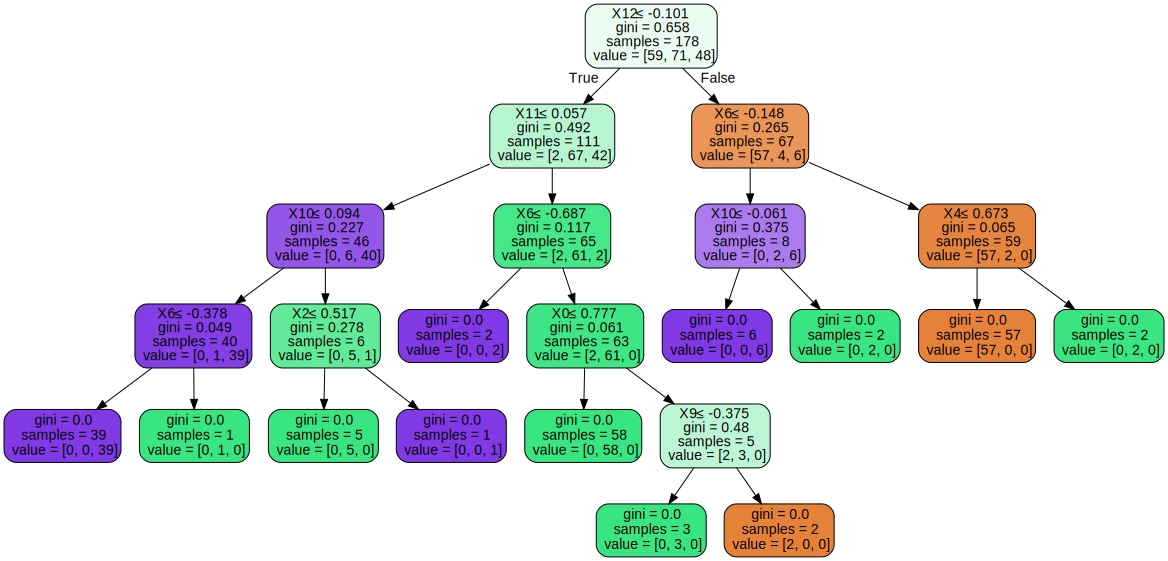

In [75]:
trainingData = tData[0].T

clf = DecisionTreeClassifier()
clf.fit(trainingData, classification)


score = clf.score(nData, classification)

print(score)

import graphviz
dot_data = sklearn.tree.export_graphviz(clf, out_file=None,
                                filled=True, rounded=True,  
                                 special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [35]:
SVM_accuracy = []

nData = tData[0].T
clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
clf.fit(nData, classification)
ND_accuracy = clf.score(nData, classification)


clf.coef_

array([[ 1.75328169,  0.56990065,  1.12611343, -1.71015272,  0.14311159,
         0.24682001,  0.80827424,  0.02300053, -0.33099256,  0.20746389,
         0.24655381,  1.31268936,  2.71091701],
       [-1.69277766, -0.88460938, -1.52112189,  0.90947384, -0.17688719,
        -0.05267009,  0.80523958,  0.38504565,  0.43614988, -2.90161434,
         1.04235912, -0.34762388, -2.49710405],
       [ 0.48851244,  0.83861896,  0.7197108 ,  0.57477273,  0.01842455,
        -0.3130735 , -1.69099727, -0.05323586, -0.68638392,  1.65784958,
        -0.96911377, -0.91676192,  0.22189252]])

In [37]:
clf.coef_[0]

13

In [38]:
clf.intercept_

array([[-1.92992533],
       [ 0.17459257],
       [-1.40862045]])

In [64]:
x = np.array(clf.coef_[0])
c = clf.intercept_[0]

In [44]:
n = np.random.randn(13)
n

array([-0.93610783, -0.18938458, -0.78776358,  0.27324562, -0.34915161,
        0.41951854,  0.42875326, -0.9825704 , -1.28085483,  0.63821276,
       -1.15560608,  0.18412049, -0.3339084 ])

In [72]:
points = []
while len(points) < 100:
    n = np.subtract(np.random.rand(13), 0.5)
    n = np.multiply(n, 0.2)
    val = np.dot(n, x) + c
    if val > -0.001 and val < 0.001:
        points.append(n)


KeyboardInterrupt: 

In [ ]:
xplot = []
yplot = []

for i in range(len(points)):
    xplot.append(np.matmul(tBeta[666][0], points[i]))
    yplot.append(np.matmul(tBeta[666][1], points[i]))

plt.scatter(xplot, yplot)
plt.show()

-2.0729945537922845e-16
0.9999999999999997
1.0
s
[0.00040746695927889595, 0.02474094392989853, 0.0254662920639204, 0.019547745869958482, 0.013676166829122687, 0.07945417494550618, 0.3837989115399678, 0.38780930340446557, 0.6880528259200508, 0.40776087810706607, 0.8606202093555755, 0.5312120639470542, 0.1778212104811626]
3.6003681933530274


<IPython.core.display.Javascript object>


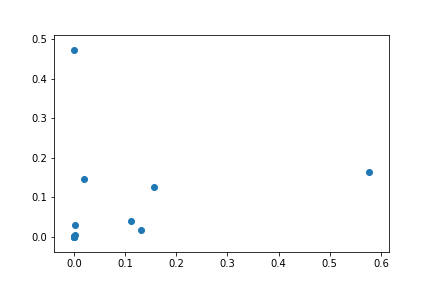

In [95]:
x = tBeta[482][0]
y = tBeta[482][1]
print(np.dot(x, y))
print(np.sum(x ** 2))
print(np.sum(y ** 2))

x = x ** 2
y = y ** 2

s = []

for i in range(len(x)):
    s.append(np.sqrt(x[i] + y[i]))

print("s")
print(sum(s))
plt.figure(0)
plt.scatter(x, y)
plt.show()